<a href="https://colab.research.google.com/github/Aniket1492/PdfML/blob/main/Custom_LLMV3_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install tesseract
!apt install tesseract-ocr
!apt install libtesseract-dev
!pip install shapely
!pip install scikit-learn

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libtesseract-dev is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [2]:

import os
import json
import pandas as pd
import numpy as np
import json
from tqdm import tqdm

from shapely.geometry import Polygon
import glob
from PIL import Image
from pytesseract import pytesseract
from lxml import etree
import ast

from sklearn.model_selection import train_test_split


In [3]:
# Open label-studio output json.

f = open('/content/project-4.json')
label_studio_data = json.load(f)

In [19]:
def calculate_iou(box_1, box_2):
    poly_1 = Polygon(box_1)
    poly_2 = Polygon(box_2)
    # print(poly_1,poly_2)
    # iou = poly_1.intersection(poly_2).area / poly_1.union(poly_2).area
    iou = poly_1.intersection(poly_2).area
    min_area = min(poly_1.area,poly_2.area)
    return iou/min_area


def hocr_to_dataframe(fp):
    doc = etree.parse(fp)
    words = []
    wordConf = []
    coords_list = []
    for path in doc.xpath('//*'):
        if 'ocrx_word' in path.values():
            coord_text = path.values()[2].split(';')[0].split(' ')[1:]
            word_coord = list(map(int, coord_text)) #x1, y1, x2, y2
            conf = [x for x in path.values() if 'x_wconf' in x][0]
            wordConf.append(int(conf.split('x_wconf ')[1]))
            words.append(path.text)
            coords_list.append(word_coord)

    dfReturn = pd.DataFrame({'word' : words,
                             'coords': coords_list,
                             'confidence' : wordConf})

    return(dfReturn)

In [20]:
print(label_studio_data)

[{'id': 7, 'annotations': [{'id': 4, 'completed_by': 1, 'result': [{'original_width': 1955, 'original_height': 2530, 'image_rotation': 0, 'value': {'x': 61.687979539641944, 'y': 7.075098814229249, 'width': 25.012787723785166, 'height': 1.0671936758893281, 'rotation': 0}, 'id': '98c80b98-0', 'from_name': 'bbox', 'to_name': 'image', 'type': 'rectangle', 'origin': 'prediction-changed'}, {'original_width': 1955, 'original_height': 2530, 'image_rotation': 0, 'value': {'x': 61.687979539641944, 'y': 7.075098814229249, 'width': 25.012787723785166, 'height': 1.0671936758893281, 'rotation': 0, 'text': ['SEQUENCE SG BIZCO PTE. LTD. (202346260R)']}, 'id': '98c80b98-0', 'from_name': 'transcription', 'to_name': 'image', 'type': 'textarea', 'origin': 'prediction-changed', 'score': 0.5}, {'original_width': 1955, 'original_height': 2530, 'image_rotation': 0, 'value': {'x': 61.687979539641944, 'y': 7.075098814229249, 'width': 25.012787723785166, 'height': 1.0671936758893281, 'rotation': 0, 'labels': ['V

In [21]:
document_data = dict()
document_data['file_name'] = []
document_data['labelled_bbox']= []

for i in range(len(label_studio_data)):
    row = label_studio_data[i]
    file_name = os.path.basename(row['data']['ocr'])
    label_list, labels, bboxes = [], [], []
    for label_ in row['annotations'][0]['result']:
        label_value = label_['value']
        x, y, w, h = label_value['x'], label_value['y'], label_value['width'], label_value['height']
        original_w , original_h = label_['original_width'], label_['original_height']

        x1 = int((x * original_w) / 100)
        y1 = int((y * original_h) / 100)
        x2 = x1 + int(original_w*w / 100)
        y2 = y1 + int(original_h*h / 100)
        try:
           label = label_value['labels']
           print(label)
           label_list.append((label, (x1,y1,x2,y2), original_h, original_w))
        except KeyError:
           var1=1

    document_data['file_name'].append(file_name)
    document_data['labelled_bbox'].append(label_list)

custom_dataset = pd.DataFrame(document_data)

['VENDOR NAME']
['SHIP TO NAME']
['INVOICE NUMBER']
['INVOICE DATE']
['PONUMBER']
['INVOICE DESCRIPTION']
['ITEM']
['UOM']
['QUANTITY']
['LINETOTAL']
['ITEM']
['UOM']
['QUANTITY']
['LINETOTAL']
['ITEM']
['UOM']
['QUANTITY']
['LINETOTAL']
['ITEM']
['UOM']
['QUANTITY']
['LINETOTAL']
['ITEM']
['UOM']
['QUANTITY']
['LINETOTAL']
['ITEM']
['UOM']
['QUANTITY']
['LINETOTAL']
['INVOICE TOTAL']
['TYPE OF DOCUMENT']
['VENDOR NAME']
['TYPE OF DOCUMENT']
['INVOICE NUMBER']
['INVOICE DESCRIPTION']
['PONUMBER']
['INVOICE DATE']
['PO DATE']
['SHIP TO NAME']
['ITEM']
['UOM']
['QUANTITY']
['LINETOTAL']
['TAX AMOUNT']
['INVOICE TOTAL']
['VENDOR NAME']
['TYPE OF DOCUMENT']
['INVOICE NUMBER']
['INVOICE DESCRIPTION']
['INVOICE DATE']
['SHIP TO NAME']
['ITEM']
['UOM']
['QUANTITY']
['LINETOTAL']
['ITEM']
['TAX AMOUNT']
['INVOICE TOTAL']
['VENDOR NAME']
['TYPE OF DOCUMENT']
['INVOICE NUMBER']
['INVOICE DESCRIPTION']
['INVOICE DATE']
['SHIP TO NAME']
['ITEM']
['UOM']
['QUANTITY']
['LINETOTAL']
['INVOICE TOTAL']

In [22]:
print(label_list)

[(['TYPE OF DOCUMENT'], (76, 330, 319, 385), 2200, 1700), (['VENDOR NAME'], (1310, 321, 1591, 351), 2200, 1700), (['INVOICE DATE'], (1002, 346, 1146, 378), 2200, 1700), (['SHIP TO NAME'], (156, 422, 406, 445), 2200, 1700), (['PONUMBER'], (1002, 509, 1106, 534), 2200, 1700), (['ITEM'], (83, 967, 834, 997), 2200, 1700), (['QUANTITY'], (1065, 965, 1125, 999), 2200, 1700), (['LINETOTAL'], (1485, 965, 1573, 997), 2200, 1700), (['ITEM'], (85, 1034, 933, 1056), 2200, 1700), (['QUANTITY'], (1062, 1029, 1125, 1063), 2200, 1700), (['LINETOTAL'], (1499, 1029, 1572, 1061), 2200, 1700), (['ITEM'], (85, 1098, 832, 1121), 2200, 1700), (['QUANTITY'], (1067, 1095, 1123, 1123), 2200, 1700), (['LINETOTAL'], (1485, 1093, 1573, 1125), 2200, 1700), (['ITEM'], (83, 1157, 935, 1187), 2200, 1700), (['QUANTITY'], (1065, 1155, 1125, 1189), 2200, 1700), (['LINETOTAL'], (1499, 1157, 1572, 1189), 2200, 1700), (['ITEM'], (85, 1221, 834, 1251), 2200, 1700), (['QUANTITY'], (1065, 1219, 1125, 1254), 2200, 1700), (['LIN

In [24]:
print(custom_dataset)

                                           file_name  \
0  20240316 201713542C Livinwall - Inv 0001_image...   
1            23 SUZLON ENERGY LIMITED 21_image_0.png   
2                      2324009 NAKODA 15_image_0.png   
3  2324023 Alliancetech International DMCC 18_ima...   
4                             INV-001042_image_0.png   
5                             INV-001043_image_0.png   
6                             INV-001049_image_0.png   
7                           Invoice INV - 0001_1.png   
8                             Invoice INV-0005_1.png   
9                             Quote QU0024 (1)_1.png   

                                       labelled_bbox  
0  [([VENDOR NAME], (1206, 179, 1695, 206), 2530,...  
1  [([VENDOR NAME], (648, 245, 1363, 282), 2530, ...  
2  [([VENDOR NAME], (644, 213, 1309, 250), 2530, ...  
3  [([VENDOR NAME], (653, 245, 1344, 279), 2530, ...  
4  [([VENDOR NAME], (1252, 185, 1778, 241), 2689,...  
5  [([VENDOR NAME], (1252, 185, 1778, 241), 2689,... 

In [30]:
label2id = {"TYPE OF DOCUMENT": 0, "VENDOR NAME": 1, "INVOICE DATE": 2,"SHIP TO NAME": 3,"PONUMBER": 4,"ITEM": 5,"QUANTITY": 6,"LINETOTAL": 7,"INVOICE TOTAL": 8,"INVOICE NUMBER": 9,"INVOICE DESCRIPTION": 10,"TAX AMOUNT": 11,"UOM": 12,"PO DATE": 13}
id2label = {v:k for k, v in label2id.items()}

In [31]:
%%time

final_list = []

for i in tqdm(custom_dataset.iterrows(), total=custom_dataset.shape[0]):
    custom_label_text = {}
    word_list = []
    ner_tags_list  = []
    bboxes_list = []

    file_name = i[1]['file_name']

    for image in glob.glob('/content/layoutlmv3/*.png'): #Make sure you add your extension or change it based on your needs
        frame_file_name = os.path.basename(image)
        if frame_file_name == file_name:
            custom_label_text['id'] = i[0]
            image_basename = os.path.basename(image)
            custom_label_text['file_name'] = image_basename
            annotations = []
            label_coord_list = i[1]['labelled_bbox']
            for label_coord in label_coord_list:
                (x1,y1,x2,y2) = label_coord[1]
                box1 = [[x1, y1], [x2, y1], [x2, y2], [x1, y2]]
                label = label_coord[0][0]
                base_name = os.path.join('/content', 'layoutlmv3',os.path.basename(image).split('.')[0])
                pytesseract.run_tesseract(image, base_name, extension='box', lang=None, config="hocr")
                hocr_file = os.path.join(base_name+'.hocr')
                hocr_df = hocr_to_dataframe(hocr_file)
                for word in hocr_df.iterrows():
                    coords = word[1]['coords']
                    (x1df,y1df,x2df,y2df) = coords
                    box2 = [[x1df, y1df], [x2df, y1df], [x2df, y2df], [x1df, y2df]]
                    words = word[1]['word']
                    overlap_perc = calculate_iou(box1,box2)
                    temp_dic = {}
                    if overlap_perc > 0.80:
                        if words != '-':
                            word_list.append(words)
                            bboxes_list.append(coords)
                            label_id = label2id[label]
                            ner_tags_list.append(label_id)

                        custom_label_text['tokens'] = word_list
                        custom_label_text['bboxes'] = bboxes_list
                        custom_label_text['ner_tags'] = ner_tags_list

    final_list.append(custom_label_text)

100%|██████████| 10/10 [13:31<00:00, 81.18s/it]

CPU times: user 13.7 s, sys: 492 ms, total: 14.2 s
Wall time: 13min 31s


In [32]:
train, test = train_test_split(final_list, random_state=21, test_size=0.3)

for detail  in final_list:
    with open('final_list_text.txt', 'a') as f:
        f.write(str(detail))
        f.write('\n')

for detail  in train:
    with open('train.txt', 'a') as f:
        f.write(str(detail))
        f.write('\n')

for detail  in test:
    with open('test.txt', 'a') as f:
        f.write(str(detail))
        f.write('\n')

In [34]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.6 MB/s eta 0:00:00


In [39]:
import json
import os
import ast
from pathlib import Path
import datasets
from PIL import Image
import pandas as pd

logger = datasets.logging.get_logger(__name__)
_CITATION = """\
@article{,
  title={},
  author={},
  journal={},
  year={},
  volume={}
}
"""
_DESCRIPTION = """\
This is a sample dataset for training layoutlmv3 model on custom annotated data.
"""

def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    w, h = image.size
    return image, (w,h)

def normalize_bbox(bbox, size):
    return [
        int(1000 * bbox[0] / size[0]),
        int(1000 * bbox[1] / size[1]),
        int(1000 * bbox[2] / size[0]),
        int(1000 * bbox[3] / size[1]),
    ]


_URLS = []

'''Edit your working directory folder path here if required.
If this file is in the same folder as the "layoutlmv3" folder keep it as it is.
'''
data_path = r'./'

class DatasetConfig(datasets.BuilderConfig):
    """BuilderConfig for InvoiceExtraction Dataset"""
    def __init__(self, **kwargs):
        """BuilderConfig for InvoiceExtraction Dataset.
        Args:
          **kwargs: keyword arguments forwarded to super.
        """
        super(DatasetConfig, self).__init__(**kwargs)


class InvoiceExtraction(datasets.GeneratorBasedBuilder):
    BUILDER_CONFIGS = [
        DatasetConfig(name="InvoiceExtraction", version=datasets.Version("1.0.0"), description="InvoiceExtraction dataset"),
    ]

    def _info(self):
        return datasets.DatasetInfo(
            description=_DESCRIPTION,
            features=datasets.Features(
                {
                    "id": datasets.Value("string"),
                    "tokens": datasets.Sequence(datasets.Value("string")),
                    "bboxes": datasets.Sequence(datasets.Sequence(datasets.Value("int64"))),
                    "ner_tags": datasets.Sequence(
                        datasets.features.ClassLabel(
                            names = ['TYPE OF DOCUMENT', 'VENDOR NAME', 'INVOICE DATE','SHIP TO NAME','PONUMBER','ITEM','QUANTITY','LINETOTAL','INVOICE TOTAL','INVOICE NUMBER','INVOICE DESCRIPTION','TAX AMOUNT','UOM','PO DATE'] #Enter the list of labels that you have here.
                            )
                    ),
                    "image_path": datasets.Value("string"),
                    "image": datasets.features.Image()
                }
            ),
            supervised_keys=None,
            citation=_CITATION,
            homepage="",
        )




    def _split_generators(self, dl_manager):
        """Returns SplitGenerators."""
        """Uses local files located with data_dir"""
        dest = os.path.join(data_path, 'layoutlmv3')

        return [
            datasets.SplitGenerator(
                name=datasets.Split.TRAIN, gen_kwargs={"filepath": os.path.join(dest, "train.txt"), "dest": dest}
            ),
            datasets.SplitGenerator(
                name=datasets.Split.TEST, gen_kwargs={"filepath": os.path.join(dest, "test.txt"), "dest": dest}
            ),
        ]

    def _generate_examples(self, filepath, dest):

        df = pd.read_csv(os.path.join(dest, 'class_list.txt'), delimiter='\s', header=None)
        id2labels = dict(zip(df[0].tolist(), df[1].tolist()))


        logger.info("⏳ Generating examples from = %s", filepath)

        item_list = []
        with open(filepath, 'r', encoding='utf-8') as f:
            for line in f:
                item_list.append(line.rstrip('\n\r'))
        print(item_list)
        for guid, fname in enumerate(item_list):
            print(fname)
            data = ast.literal_eval(fname)
            image_path = os.path.join(dest, data['file_name'])
            image, size = load_image(image_path)
            boxes = data['bboxes']

            text = data['tokens']
            label = data['ner_tags']

            #print(boxes)
            #for i in boxes:
            #  print(i)
            boxes = [normalize_bbox(box, size) for box in boxes]
            flag=0
            #print(image_path)
            for i in boxes:
              #print(i)
              for j in i:
                if j>1000:
                  flag+=1
                  #print(j)
                  pass
            if flag>0: print(image_path)

            yield guid, {"id": str(guid), "tokens": text, "bboxes": boxes, "ner_tags": label, "image_path": image_path, "image": image}


In [36]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q datasets seqeval
!pip install accelerate -U

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 61.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.2 MB/s eta 0:00:00
     ━━━━

In [40]:
from datasets import load_dataset

# this dataset uses the new Image feature :)
dataset = load_dataset("./layoutlmv3.py")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:926: FutureWarning: The repository for layoutlmv3 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at ./layoutlmv3.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/download/streaming_download_manager.py:784: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return pd.read_csv(xopen(filepath_or_buffer, "rb", download_config=download_config), **kwargs)


["{'id': 3, 'file_name': '2324023 Alliancetech International DMCC 18_image_0.png', 'tokens': ['RAKHOH', 'INDUSTRIES', 'PVT.', 'LTD.', 'EXPORT', 'INVOICE', ' ', '2324023', ' ', 'GSTIN', ':', '27AAGCR4911E1ZJ', ' ', '18-11-2023', ' ', 'STEAM', 'TEAM', 'AUSTRALIA', 'PTY', 'LTD', ' ', 'LOT-1', 'of', 'Solid', 'fuel', 'fired', 'water', 'tube', ' ', ' ', ' ', '20,000.00', ' ', '20,000.00', ' '], 'bboxes': [[651, 247, 850, 279], [868, 247, 1135, 279], [1151, 247, 1244, 279], [1260, 247, 1349, 279], [723, 463, 961, 512], [986, 463, 1224, 512], [26, 427, 1917, 2472], [401, 643, 520, 665], [26, 427, 1917, 2472], [709, 643, 789, 665], [803, 648, 808, 666], [822, 643, 1087, 665], [26, 427, 1917, 2472], [383, 686, 540, 708], [26, 427, 1917, 2472], [1199, 843, 1291, 865], [1300, 843, 1377, 865], [1387, 843, 1542, 865], [1553, 843, 1605, 865], [1617, 843, 1669, 865], [26, 427, 1917, 2472], [129, 1406, 207, 1428], [222, 1406, 250, 1428], [260, 1406, 325, 1428], [337, 1405, 390, 1428], [401, 1405, 467, 

Generating test split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/download/streaming_download_manager.py:784: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return pd.read_csv(xopen(filepath_or_buffer, "rb", download_config=download_config), **kwargs)


["{'id': 1, 'file_name': '23 SUZLON ENERGY LIMITED 21_image_0.png', 'tokens': ['RAKHOH', 'INDUSTRIES', 'PVT.', 'LTD.', 'PROFORMA-INVOICE', '23', 'GSTIN', ':', '27AAGCR4911E1ZJ', '4300323919', '     ', '4/21/2023', '     ', '4/19/2023', 'SUZLON', 'ENERGY', 'LIMITED', 'NOSE', 'CONE', 'CAGE', '7', '812000.00', '146160.00'], 'bboxes': [[647, 247, 852, 279], [870, 247, 1145, 279], [1161, 248, 1256, 279], [1273, 248, 1365, 279], [665, 565, 1275, 615], [478, 704, 509, 726], [762, 705, 828, 723], [839, 709, 844, 724], [856, 705, 1074, 723], [1575, 704, 1753, 726], [1433, 692, 1898, 737], [419, 748, 566, 770], [38, 743, 914, 847], [1605, 750, 1723, 768], [1074, 911, 1193, 935], [1208, 911, 1328, 935], [1340, 911, 1459, 935], [141, 1373, 219, 1397], [232, 1373, 314, 1397], [326, 1373, 406, 1397], [1015, 1370, 1030, 1394], [1735, 1370, 1885, 1394], [1736, 1965, 1885, 1989]], 'ner_tags': [1, 1, 1, 1, 0, 9, 10, 10, 10, 4, 4, 2, 2, 13, 3, 3, 3, 5, 5, 5, 6, 7, 11]}", "{'id': 2, 'file_name': '2324009 

In [41]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image_path', 'image'],
        num_rows: 7
    })
    test: Dataset({
        features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image_path', 'image'],
        num_rows: 3
    })
})


In [42]:
print(dataset["train"].features)

{'id': Value(dtype='string', id=None), 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'bboxes': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None), 'ner_tags': Sequence(feature=ClassLabel(names=['TYPE OF DOCUMENT', 'VENDOR NAME', 'INVOICE DATE', 'SHIP TO NAME', 'PONUMBER', 'ITEM', 'QUANTITY', 'LINETOTAL', 'INVOICE TOTAL', 'INVOICE NUMBER', 'INVOICE DESCRIPTION', 'TAX AMOUNT', 'UOM', 'PO DATE'], id=None), length=-1, id=None), 'image_path': Value(dtype='string', id=None), 'image': Image(decode=True, id=None)}


In [69]:
dataset["train"].features

{'id': Value(dtype='string', id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'bboxes': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['TYPE OF DOCUMENT', 'VENDOR NAME', 'INVOICE DATE', 'SHIP TO NAME', 'PONUMBER', 'ITEM', 'QUANTITY', 'LINETOTAL', 'INVOICE TOTAL', 'INVOICE NUMBER', 'INVOICE DESCRIPTION', 'TAX AMOUNT', 'UOM', 'PO DATE'], id=None), length=-1, id=None),
 'image_path': Value(dtype='string', id=None),
 'image': Image(decode=True, id=None)}

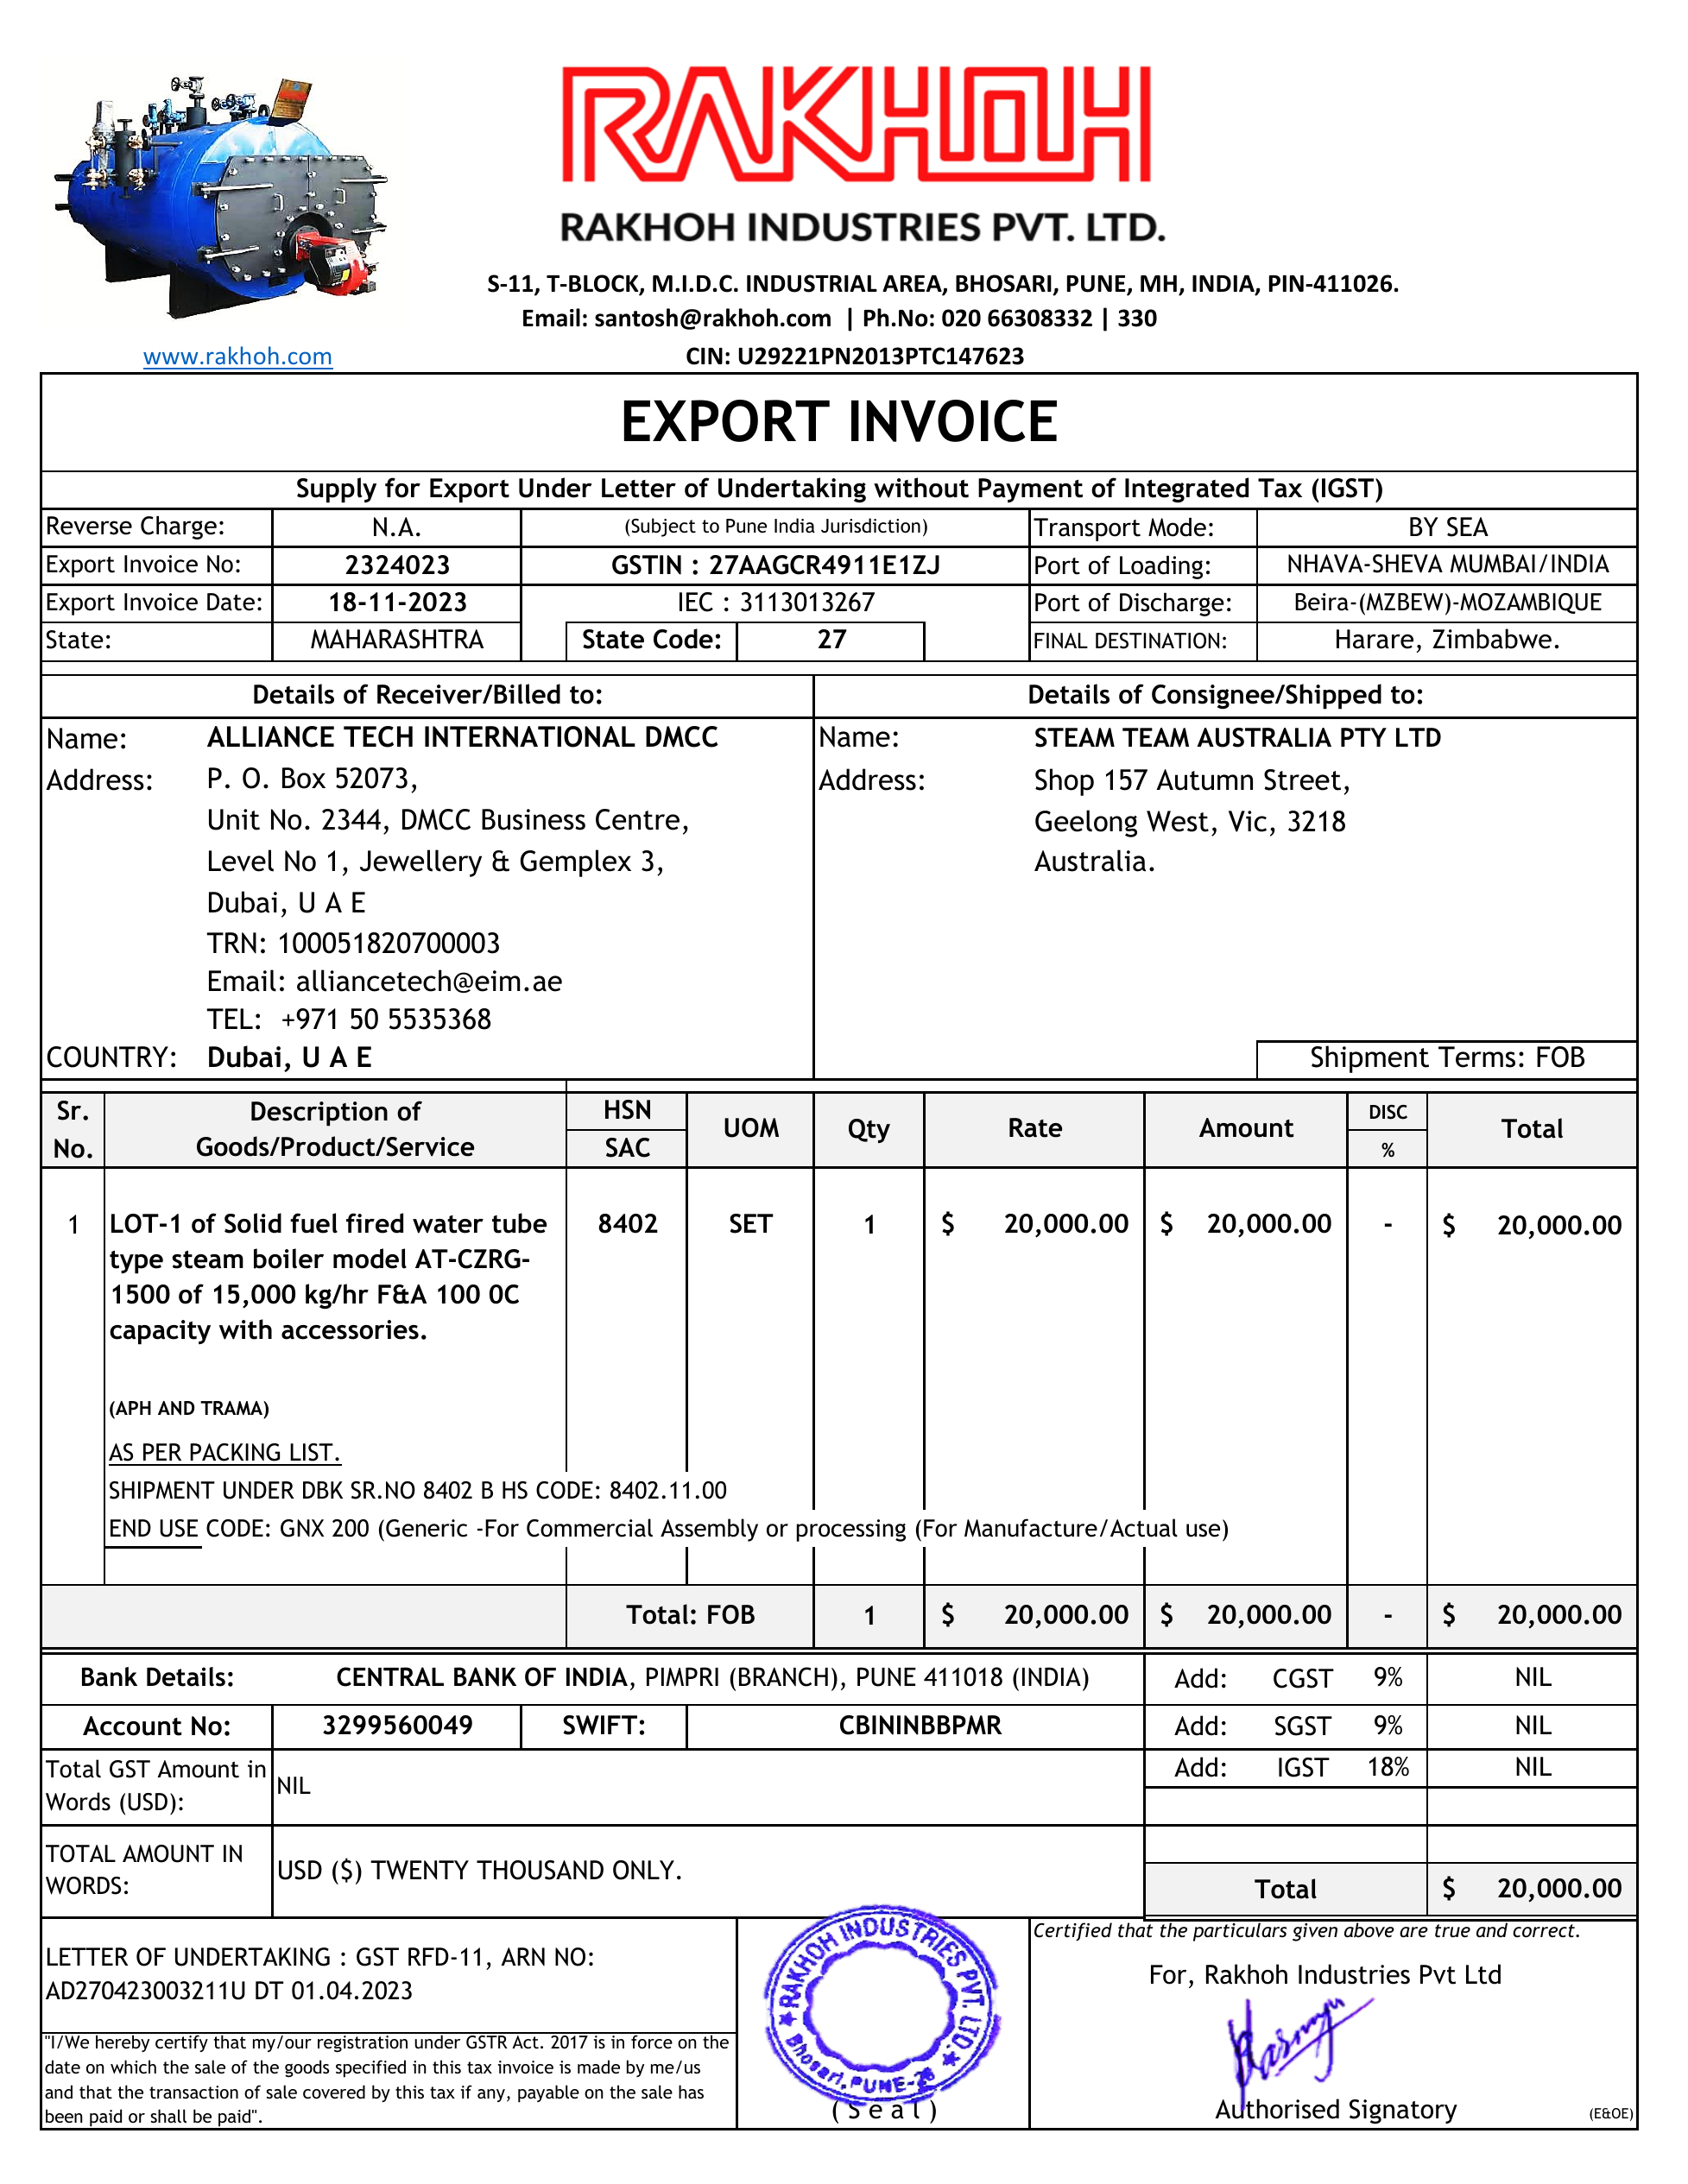

In [43]:
example = dataset["train"][0]
example["image"]

In [44]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q datasets seqeval
!pip install accelerate -U

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [45]:
from datasets import load_dataset

# this dataset uses the new Image feature :)
dataset = load_dataset("./layoutlmv3.py")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:926: FutureWarning: The repository for layoutlmv3 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at ./layoutlmv3.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [46]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image_path', 'image'],
        num_rows: 7
    })
    test: Dataset({
        features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image_path', 'image'],
        num_rows: 3
    })
})

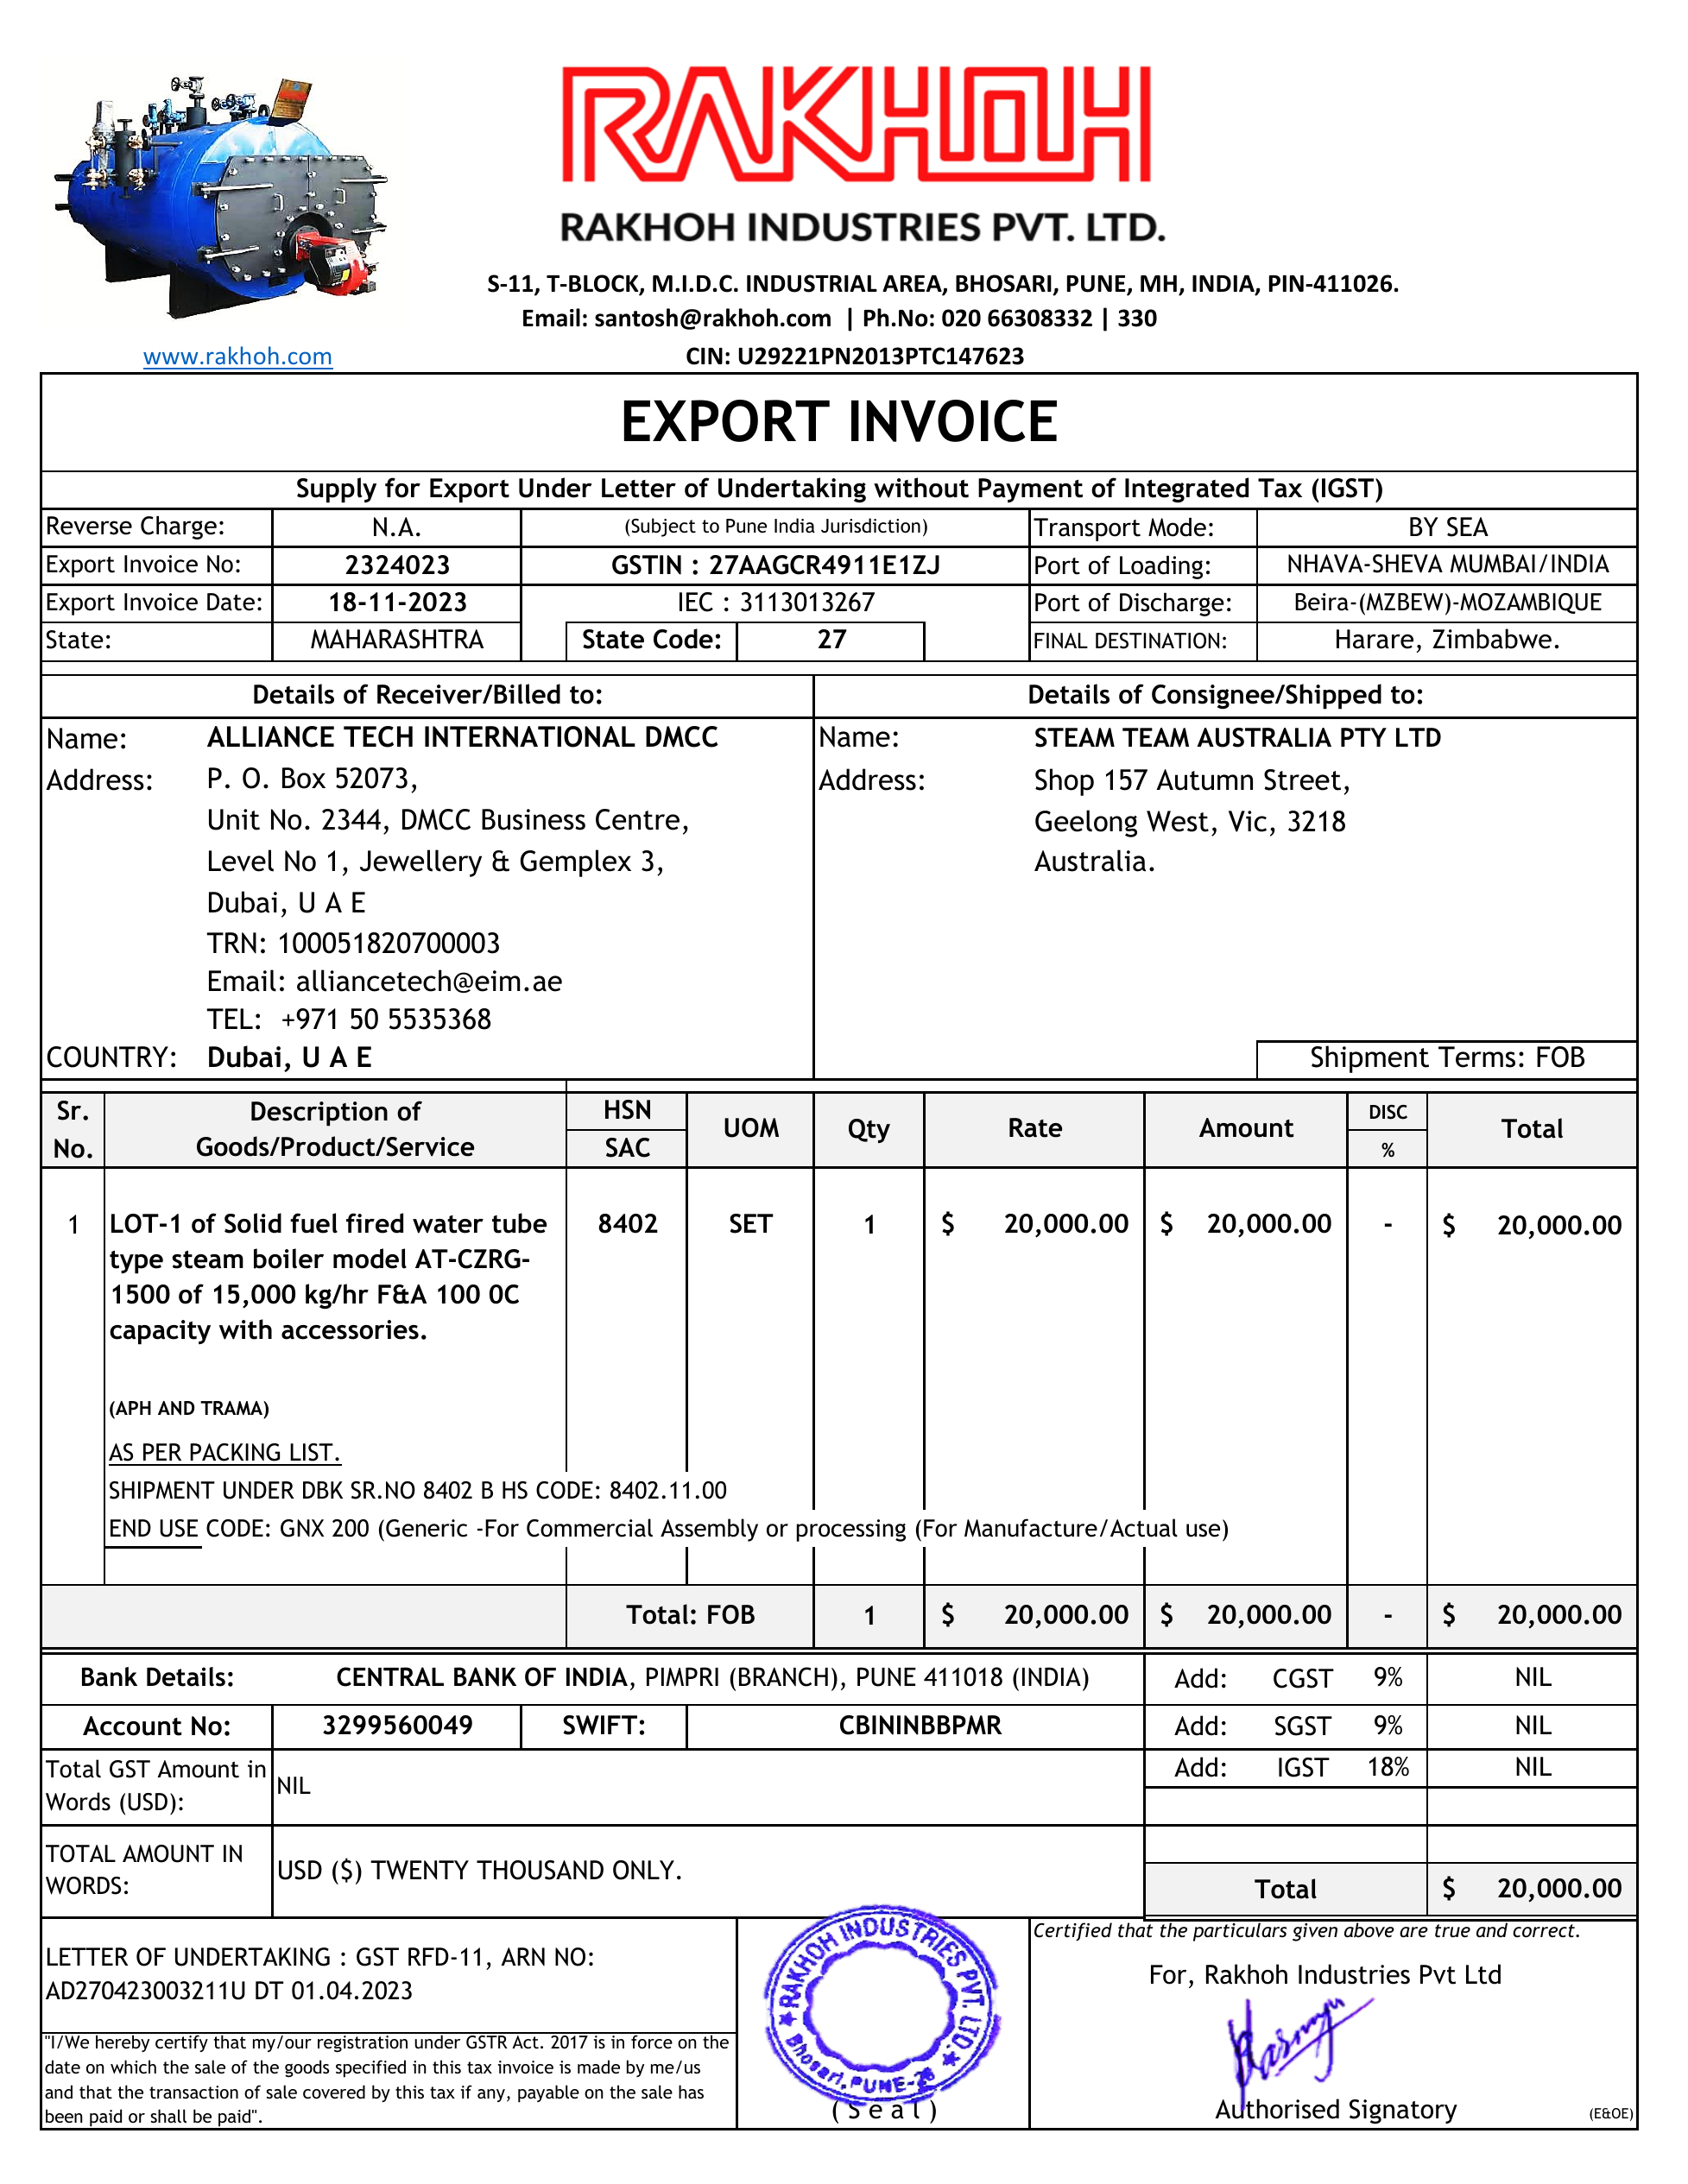

In [47]:
example = dataset["train"][0]
example["image"]

In [48]:
from transformers import AutoProcessor

# we'll use the Auto API here - it will load LayoutLMv3Processor behind the scenes,
# based on the checkpoint we provide from the hub
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/275 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/856 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

In [70]:
processor

LayoutLMv3Processor:
- image_processor: LayoutLMv3ImageProcessor {
  "_valid_processor_keys": [
    "images",
    "do_resize",
    "size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "apply_ocr",
    "ocr_lang",
    "tesseract_config",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "apply_ocr": false,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "LayoutLMv3ImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "ocr_lang": null,
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  },
  "tesseract_config": ""
}

- tokenizer: LayoutLMv3TokenizerFast(name_or_path='microsoft/layoutlmv3-base', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_tok

In [49]:
import numpy as np
from datasets.features import ClassLabel

return_entity_level_metrics = False

features = dataset["train"].features
column_names = dataset["train"].column_names
image_column_name = "image"
text_column_name = "tokens"
boxes_column_name = "bboxes"
label_column_name = "ner_tags"

# In the event the labels are not a `Sequence[ClassLabel]`, we will need to go through the dataset to get the
# unique labels.
def get_label_list(labels):
    unique_labels = set()
    for label in labels:
        unique_labels = unique_labels | set(label)
    label_list = list(unique_labels)
    label_list.sort()
    return label_list


def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]


# Tokenize the inputs
def prepare_examples(examples):
    images = examples[image_column_name]
    words = examples[text_column_name]
    boxes = examples[boxes_column_name]
    word_labels = examples[label_column_name]

    encoding = processor(images, words, boxes=boxes, word_labels=word_labels,
                       truncation=True, padding="max_length")

    return encoding


def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }


if isinstance(features[label_column_name].feature, ClassLabel):
    label_list = features[label_column_name].feature.names
    # No need to convert the labels since they are already ints.
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
else:
    label_list = get_label_list(dataset["train"][label_column_name])
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
num_labels = len(label_list)

In [50]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

# we need to define custom features for `set_format` (used later on) to work properly
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
})

train_dataset = dataset["train"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)
eval_dataset = dataset["test"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)

Map:   0%|          | 0/7 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

In [51]:
from datasets import load_metric

metric = load_metric("seqeval")

<ipython-input-51-edef154daec7>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [52]:
from transformers import LayoutLMv3ForTokenClassification

model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base",
                                                         id2label=id2label,
                                                         label2id=label2id)

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [56]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test",
                                  max_steps=100,
                                  per_device_train_batch_size=2,
                                  per_device_eval_batch_size=2,
                                  learning_rate=1e-5,
                                  evaluation_strategy="steps",
                                  eval_steps=100,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1")

In [57]:
from transformers.data.data_collator import default_data_collator

# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

In [58]:
trainer.train()

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,No log,0.613121,0.693878,0.618182,0.653846,0.878571


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: VENDOR NAME seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: TYPE OF DOCUMENT seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: INVOICE NUMBER seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: INVOICE DESCRIPTION seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PONUMBER seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-p

TrainOutput(global_step=100, training_loss=0.5345943069458008, metrics={'train_runtime': 2277.2694, 'train_samples_per_second': 0.088, 'train_steps_per_second': 0.044, 'total_flos': 46451331225600.0, 'train_loss': 0.5345943069458008, 'epoch': 25.0})

In [66]:
trainer.evaluate()

{'eval_loss': 0.6131213307380676,
 'eval_precision': 0.6938775510204082,
 'eval_recall': 0.6181818181818182,
 'eval_f1': 0.6538461538461539,
 'eval_accuracy': 0.8785714285714286,
 'eval_runtime': 8.6647,
 'eval_samples_per_second': 0.346,
 'eval_steps_per_second': 0.231,
 'epoch': 25.0}

In [73]:
model.config.to_json_file("config.json")

In [76]:
trainer.save_model("/content/test")

In [77]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained("/content/test/")